In [32]:
# === Colab: SVM with encoding + targeted log1p (2-fold CV) ===
!pip -q install scikit-learn pandas numpy

import numpy as np, pandas as pd, os, joblib
from google.colab import files

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

# ---------------- Load & de-dup ----------------
df = pd.read_csv('/content/data.csv')
df = df.drop_duplicates()

# ---- Infer label column (or set LABEL_COL = "Class") ----
LABEL_COL = None
label_like = {"label","labels","target","class","classes","category","y","outcome","diagnosis"}
for c in df.columns:
    if c.strip().lower() in label_like:
        LABEL_COL = c
        break
if LABEL_COL is None:
    n = len(df)
    for c in df.columns:
        nu = df[c].nunique(dropna=False)
        if 2 <= nu <= min(50, max(2, int(0.2*n))):
            LABEL_COL = c
            break
if LABEL_COL is None and "Class" in df.columns:
    LABEL_COL = "Class"

feat_cols = [c for c in df.columns if c != LABEL_COL]


cat_name_hints = {
    "asm_commands_cmc", "asm_commands_cwd", "asm_commands_faddp", "asm_commands_fchs",
    "asm_commands_fdiv", "asm_commands_fdivr", "asm_commands_fistp", "asm_commands_jno",
    "asm_commands_outs", "asm_commands_rcr", "asm_commands_sal", "asm_commands_scas",
    "asm_commands_sidt"
}

hint_cols_present = [c for c in feat_cols if c in cat_name_hints]
obj_cols = [c for c in feat_cols if df[c].dtype == "object"]
low_card_cols = [c for c in feat_cols if pd.api.types.is_numeric_dtype(df[c]) and df[c].nunique() <= 5]

cat_cols = sorted(set(hint_cols_present + obj_cols + low_card_cols))
num_cols = [c for c in feat_cols if c not in cat_cols]

print(f"[Info] Using {len(cat_cols)} categorical columns (encoded) and {len(num_cols)} numeric columns.")

y = df[LABEL_COL].astype(str).to_numpy()

def clip_nonneg(X):
    return np.maximum(X, 0)

if len(num_cols) > 0:
    feat_meta = df[num_cols]
    heavy_mask = (feat_meta.max() > 100) | (feat_meta.nunique() > 50)
    heavy_idx = np.where(heavy_mask.values)[0]
else:
    heavy_idx = np.array([], dtype=int)

def log1p_selected(Z, idx):
    Z2 = np.zeros_like(Z, dtype=float)
    if len(idx):
        Z2[:, idx] = np.log1p(Z[:, idx])
    return Z2

num_expander = FeatureUnion([
    ("id",    FunctionTransformer(lambda Z: Z, accept_sparse=False)),
    ("log1p", FunctionTransformer(log1p_selected, kw_args={"idx": heavy_idx}, accept_sparse=False)),
])

numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("clip",   FunctionTransformer(clip_nonneg, accept_sparse=False)),
    ("expand", num_expander),
    ("minmax", MinMaxScaler()),
])

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

transformers = []
if num_cols:
    transformers.append(("num", numeric_pipe, num_cols))
if cat_cols:
    transformers.append(("cat", categorical_pipe, cat_cols))

pre = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
    sparse_threshold=0.0
)

X = df[feat_cols].to_numpy()
n_features = X.shape[1]
k = min(n_features, max(10, int(0.9 * n_features)))

pipe = Pipeline([
    ("pre", pre),
    ("chi2", SelectKBest(chi2, k=k)),
    ("std", StandardScaler(with_mean=True, with_std=True)),
    ("svc", SVC(kernel="rbf", class_weight="balanced"))
])

Xtr, Xte, ytr, yte = train_test_split(df[feat_cols], y, test_size=0.2, stratify=y, random_state=42)

param_dist = {
    "svc__C":     np.logspace(-1, 3, 30),
    "svc__gamma": np.logspace(-6, 0, 30),
}
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring="f1_macro",
    n_jobs=-1,
    cv=cv,
    random_state=42,
    verbose=1
)
search.fit(Xtr, ytr)

# ---- Evaluation ----
best = search.best_estimator_
yp = best.predict(Xte)
acc = accuracy_score(yte, yp)
f1m = f1_score(yte, yp, average="macro")
print("Categorical columns encoded:", cat_cols)
print("Best params:", search.best_params_)
print(f"Test Accuracy: {acc:.4f}  |  Macro-F1: {f1m:.4f}")
print("\nClassification report:\n", classification_report(yte, yp, zero_division=0))

[Info] Using 13 categorical columns (encoded) and 55 numeric columns.
Fitting 2 folds for each of 25 candidates, totalling 50 fits
Categorical columns encoded: ['asm_commands_cmc', 'asm_commands_cwd', 'asm_commands_faddp', 'asm_commands_fchs', 'asm_commands_fdiv', 'asm_commands_fdivr', 'asm_commands_fistp', 'asm_commands_jno', 'asm_commands_outs', 'asm_commands_rcr', 'asm_commands_sal', 'asm_commands_scas', 'asm_commands_sidt']
Best params: {'svc__gamma': np.float64(0.005298316906283708), 'svc__C': np.float64(41.753189365604)}
Test Accuracy: 0.9829  |  Macro-F1: 0.9744

Classification report:
               precision    recall  f1-score   support

           1       0.97      0.97      0.97       301
           2       1.00      0.99      0.99       496
           3       0.99      0.99      0.99       589
           4       1.00      0.98      0.99        95
           5       0.89      1.00      0.94         8
           6       0.93      0.99      0.96       144
           7       0

In [28]:
from sklearn.metrics import accuracy_score
yp_tr = best.predict(Xtr)
yp_te = best.predict(Xte)

train_err = 1.0 - accuracy_score(ytr, yp_tr)
test_err  = 1.0 - accuracy_score(yte, yp_te)

print(f"Train Error: {train_err:.4f}")
print(f"Test  Error: {test_err:.4f}")

Train Error: 0.0058
Test  Error: 0.0171


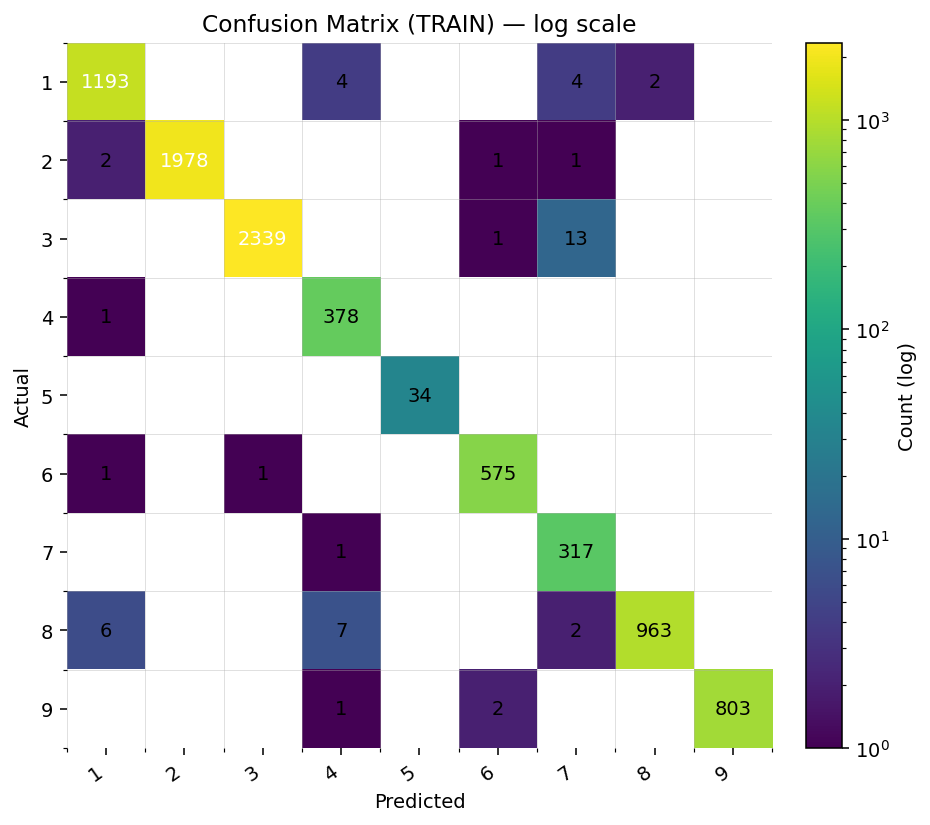

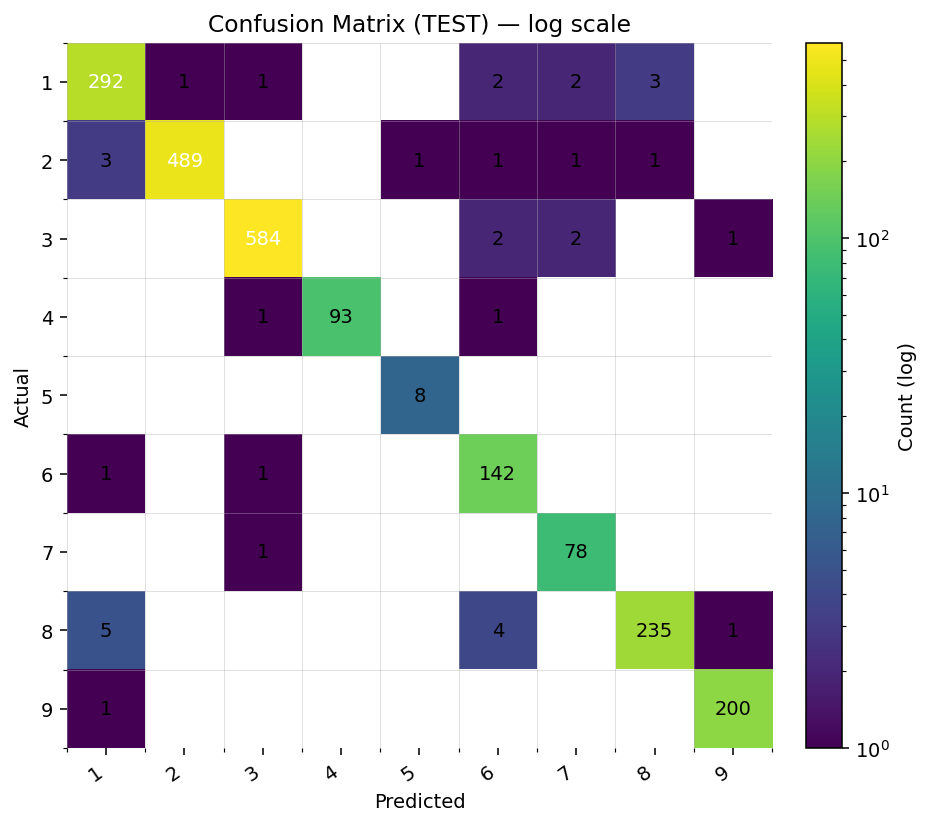

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os

def plot_cm_log(cm_df, title):
    labels = cm_df.index.astype(str).tolist()
    cm = cm_df.values.astype(float)

    vmax = float(cm.max())
    if vmax <= 1:
        vmax = 2.0

    cm_masked = np.ma.masked_less_equal(cm, 0.0)

    fig, ax = plt.subplots(figsize=(7, 6), dpi=140)
    im = ax.imshow(cm_masked, norm=LogNorm(vmin=1, vmax=vmax))
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=35, ha="right")
    ax.set_yticklabels(labels)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Count (log)")

    half = vmax / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0:
                ax.text(j, i, int(cm[i, j]), ha="center", va="center",
                        fontsize=10, color="white" if cm[i, j] >= half else "black")

    ax.set_xticks(np.arange(-.5, cm.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, cm.shape[0], 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.5, alpha=0.4)
    for s in ax.spines.values():
        s.set_visible(False)
    fig.tight_layout()
    plt.show()
    return fig

os.makedirs("artifacts", exist_ok=True)
plot_cm_log(cm_train, "Confusion Matrix (TRAIN) — log scale").savefig(
    "artifacts/confusion_matrix_train_log.png", dpi=180, bbox_inches="tight"
)
plot_cm_log(cm_test, "Confusion Matrix (TEST) — log scale").savefig(
    "artifacts/confusion_matrix_test_log.png", dpi=180, bbox_inches="tight"
)


In [30]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

yp_val = cross_val_predict(search.best_estimator_, Xtr, ytr, cv=cv, method='predict', n_jobs=-1)
yp_te  = best.predict(Xte)

val_err = 1.0 - accuracy_score(ytr, yp_val)
test_err = 1.0 - accuracy_score(yte, yp_te)

print(f"Validation Error: {val_err:.4f}")
print(f"Test Error: {test_err:.4f}")


Validation Error: 0.0239
Test Error: 0.0171


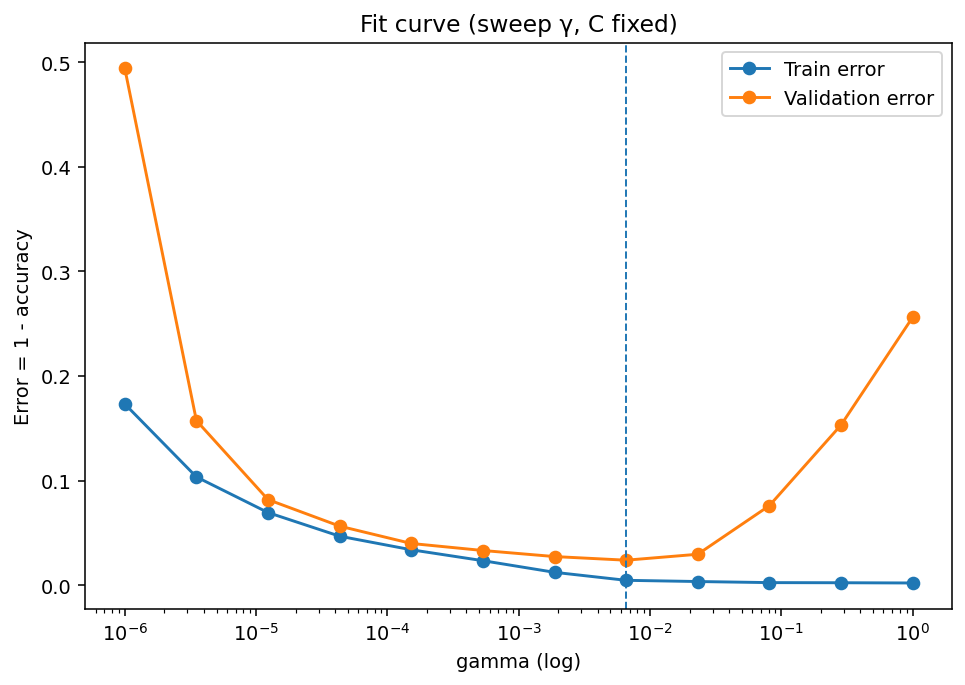

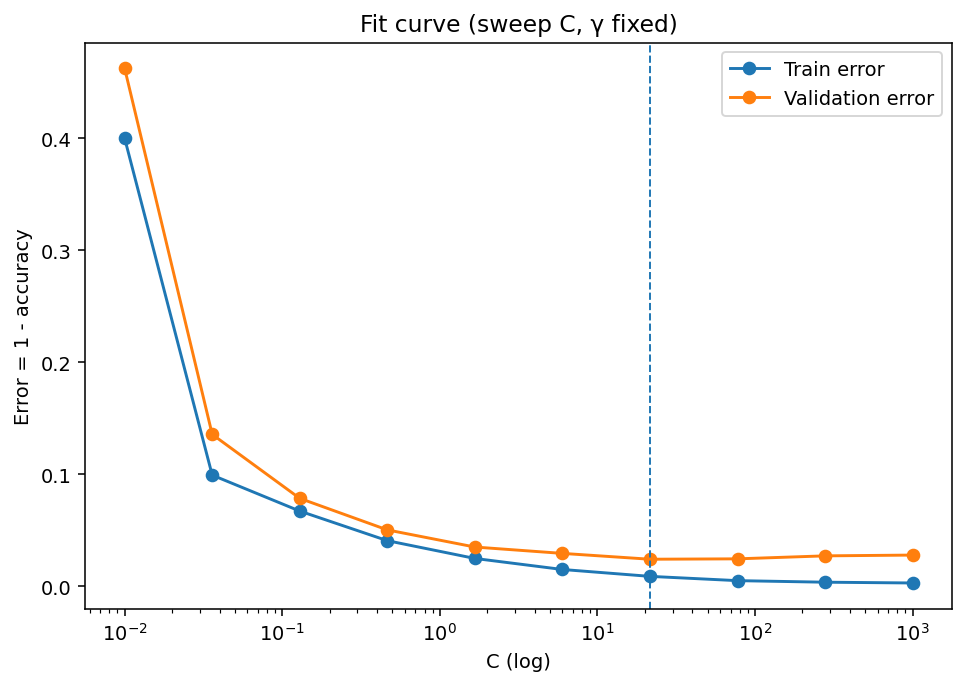

Chosen hyperparams: C=21.54, gamma=0.00658
Train error=0.0078 | Val error=0.0244 | Test error=0.0181
Diagnosis: Good fit


In [33]:
import numpy as np, pandas as pd, os, matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

base = search.best_estimator_
bp   = search.best_params_.copy()

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

def sweep_param(est, X, y, pname, grid):
    tr_err, va_err = [], []
    for v in grid:
        m = clone(est).set_params(**{pname: float(v)})
        m.fit(X, y)
        tr_err.append(1.0 - accuracy_score(y, m.predict(X)))
        va_acc = cross_val_score(m, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()
        va_err.append(1.0 - va_acc)
    return np.array(tr_err), np.array(va_err)

def diagnose(train_e, val_e, gap=0.08, high=0.25):
    if (val_e - train_e) > gap and train_e < high: return "Overfitting"
    if train_e > high and val_e > high and abs(val_e - train_e) < gap: return "Underfitting"
    return "Good fit"

os.makedirs("artifacts", exist_ok=True)

C_fix = float(bp.get("svc__C", 1.0))
gammas = np.logspace(-6, 0, 12)
est_g = clone(base).set_params(**{"svc__C": C_fix})
tr_g, va_g = sweep_param(est_g, Xtr, ytr, "svc__gamma", gammas)
i_best_g = int(np.argmin(va_g))
g_best = float(gammas[i_best_g])

plt.figure(figsize=(7,5), dpi=140)
plt.semilogx(gammas, tr_g, marker="o", label="Train error")
plt.semilogx(gammas, va_g, marker="o", label="Validation error")
plt.axvline(g_best, ls="--", lw=1)
plt.title("Fit curve (sweep γ, C fixed)")
plt.xlabel("gamma (log)"); plt.ylabel("Error = 1 - accuracy"); plt.legend(); plt.tight_layout()
plt.savefig("artifacts/fitting_graph_gamma.png", dpi=180, bbox_inches="tight")
plt.show()

g_fix = float(bp.get("svc__gamma", g_best))
Cs = np.logspace(-2, 3, 10)
est_c = clone(base).set_params(**{"svc__gamma": g_fix})
tr_c, va_c = sweep_param(est_c, Xtr, ytr, "svc__C", Cs)
i_best_c = int(np.argmin(va_c))
C_best = float(Cs[i_best_c])

plt.figure(figsize=(7,5), dpi=140)
plt.semilogx(Cs, tr_c, marker="o", label="Train error")
plt.semilogx(Cs, va_c, marker="o", label="Validation error")
plt.axvline(C_best, ls="--", lw=1)
plt.title("Fit curve (sweep C, γ fixed)")
plt.xlabel("C (log)"); plt.ylabel("Error = 1 - accuracy"); plt.legend(); plt.tight_layout()
plt.savefig("artifacts/fitting_graph_C.png", dpi=180, bbox_inches="tight")
plt.show()

chosen = clone(base).set_params(**{"svc__C": C_best, "svc__gamma": g_best})
chosen.fit(Xtr, ytr)
train_err = 1.0 - accuracy_score(ytr, chosen.predict(Xtr))
val_acc   = cross_val_score(chosen, Xtr, ytr, cv=cv, scoring="accuracy", n_jobs=-1).mean()
val_err   = 1.0 - val_acc
test_err  = 1.0 - accuracy_score(yte, chosen.predict(Xte))
diag      = diagnose(train_err, val_err)

print(f"Chosen hyperparams: C={C_best:.4g}, gamma={g_best:.3g}")
print(f"Train error={train_err:.4f} | Val error={val_err:.4f} | Test error={test_err:.4f}")
print(f"Diagnosis: {diag}")

In [31]:
!pip -q install scikit-learn pandas numpy

import numpy as np, pandas as pd, os, joblib
from google.colab import files
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

df = pd.read_csv('/content/data.csv')

LABEL_COL = None
label_like = {"label","labels","target","class","classes","category","y","outcome","diagnosis"}
for c in df.columns:
    if c.strip().lower() in label_like:
        LABEL_COL = c
        break
if LABEL_COL is None:
    n = len(df)
    for c in df.columns:
        nu = df[c].nunique(dropna=False)
        if 2 <= nu <= min(50, max(2,int(0.2*n))):
            LABEL_COL = c
            break
if LABEL_COL is None:
    raise ValueError("Couldn't infer label column. Please set LABEL_COL to the correct column name.")

feat_cols = [c for c in df.columns if c != LABEL_COL and pd.api.types.is_numeric_dtype(df[c])]
X = df[feat_cols].to_numpy()
y = df[LABEL_COL].astype(str).to_numpy()

def clip_nonneg(X):
    return np.maximum(X, 0)

def identity_transformer(Z):
    return Z

def log1p_transformer(Z):
    return np.log1p(Z)

expander = FeatureUnion([
    ("id",    FunctionTransformer(identity_transformer, accept_sparse=False)),
    ("log1p", FunctionTransformer(log1p_transformer,   accept_sparse=False)),
])

n_features = X.shape[1]
k = min(n_features, max(10, int(0.9*n_features)))

pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("clip",   FunctionTransformer(clip_nonneg, accept_sparse=False)),
    ("minmax", MinMaxScaler()),
    ("expand", expander),
    ("chi2",   SelectKBest(chi2, k=k)),
    ("std",    StandardScaler(with_mean=True, with_std=True)),
    ("svc",    SVC(kernel="rbf", class_weight="balanced"))
])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

param_dist = {
    "svc__C":     np.logspace(-1, 3, 30),   # 0.1 .. 1000
    "svc__gamma": np.logspace(-6, 0, 30),   # 1e-6 .. 1
}
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    pipe, param_distributions=param_dist, n_iter=25, scoring="f1_macro",
    n_jobs=-1, cv=cv, random_state=42, verbose=1
)
search.fit(Xtr, ytr)

best = search.best_estimator_
yp_test = best.predict(Xte)
acc_test = accuracy_score(yte, yp_test)
f1m_test = f1_score(yte, yp_test, average="macro")

yp_train = best.predict(Xtr)
acc_train = accuracy_score(ytr, yp_train)
f1m_train = f1_score(ytr, yp_train, average="macro")


print("Best params:", search.best_params_)
print(f"Train Accuracy: {acc_train:.4f}  |  Macro-F1: {f1m_train:.4f}")
print(f"Test Accuracy: {acc_test:.4f}  |  Macro-F1: {f1m_test:.4f}")
print("\nClassification report:\n", classification_report(yte, yp_test, zero_division=0))